# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
import util.misc as utils
from dataset.data import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    HFDataset,
    HFDataLoader, 
    create_augment_list,
    plot_sample,
    seed_everything,
)
from train_binary_cl2 import seed_worker
from config import *

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
RANDOM = True
EASY_PRETRAINING = False
FINETUNING = True

In [4]:
if RANDOM: 
    if EASY_PRETRAINING:
            df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt_easy.csv'))
            df_genes_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt_easy.csv'))
    else:
            df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt.csv'))
            df_genes_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt.csv'))
else:
    df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
    df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))


if RANDOM:
    if EASY_PRETRAINING:
        subset_train_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_training_nt_easy.txt")
        subset_val_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_val_sampled_nt_easy.txt") # gene_pairs_val_sampled_nt.txt it is also HQ
    else:
        if FINETUNING:
            subset_train_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_train_val_fine_tuning_nt.txt")
            subset_val_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_test_sampled_nt.txt") # gene_pairs_val_sampled_nt.txt it is also HQ
            subset_test_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_test_sampled_nt.txt")
        else:
            subset_train_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_training_nt.txt")
            subset_val_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_val_sampled_nt.txt") # gene_pairs_val_sampled_nt.txt it is also HQ
            subset_test_nt = os.path.join(rna_rna_files_dir, 'RANDOM', f"gene_pairs_test_sampled_nt.txt")
else:
    subset_train_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_training_nt.txt") #gene_pairs_training_nt_HQ
    subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_nt_HQ.txt")
    subset_test_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_test_nt_HQ.txt")
    

with open(subset_train_nt, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)
    
with open(subset_val_nt, "rb") as fp:  # Unpickling
    list_val = pickle.load(fp)
    
if EASY_PRETRAINING == False:
    with open(subset_test_nt, "rb") as fp:  # Unpickling
        list_test = pickle.load(fp)

# Esecuzione data loader train

In [5]:
vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

# pos_multipliers = {15:0.2, 
#                    25:0.3,
#                    50:0.2, 
#                    100:0.23, 
#                    10_000_000: 0.07}
# neg_multipliers = pos_multipliers

if EASY_PRETRAINING:
    pos_multipliers = {15:0.2, 
               25:0.3,
               50:0.2, 
               100:0.23, 
               10_000_000: 0.07}

    neg_multipliers = {15:0.05, 
                       28:0.2,

                       40:0.08,
                       50:0.05,
                       60:0.1,

                       80:0.03,
                       90:0.03,
                       100:0.03,

                       110:0.03,

                       120:0.1,

                       140:0.05,
                       160:0.03,
                       180:0.03,
                       200:0.02,
                       220:0.02,
                       240:0.01,
                       260:0.01,

                       10_000_000: 0.1}

else:
    pos_multipliers = {15:0.2, 
                   25:0.3,
                   50:0.2, 
                   100:0.23,
                   100_000_000:0.07}
    neg_multipliers = pos_multipliers


policies_train = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
    
    
dataset_train = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_train_nt,
        augment_policies=policies_train,
)

In [6]:
np.sum(list(neg_multipliers.values()))

1.0

In [7]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/172975 [00:00<?, ?it/s]

  0%|          | 0/172975 [00:00<?, ?it/s]

  0%|          | 0/172975 [00:00<?, ?it/s]

In [8]:
# plot_sample(sample, plot_interaction_negatives=True)

In [9]:
df_len.label.value_counts()

n    520596
p    517254
Name: label, dtype: int64

In [10]:
df_len.sort_values('length').head(500).label.value_counts()

n    278
p    222
Name: label, dtype: int64

In [11]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

0.875

In [12]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

1.7125

In [13]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

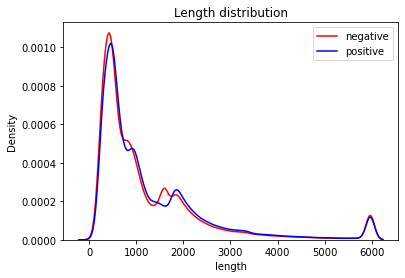

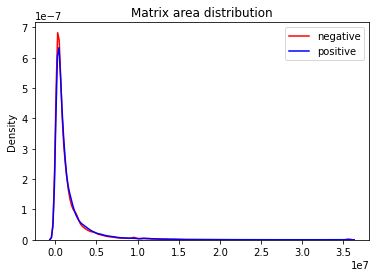

In [14]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

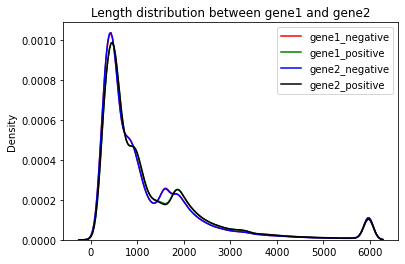

In [15]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [16]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

n    52300
p    42993
Name: label, dtype: int64


p    152627
n    150764
Name: label, dtype: int64


In [17]:
# dataset_train = RNADatasetNT(
#     gene2info=df_genes_nt,
#     interactions=df_nt,
#     subset_file=subset_train_nt,
#     augment_policies=policies_train,
#     data_dir = os.path.join(embedding_dir, '32'),
# )

# all_couples = set(df_nt.couples_id)

# augment_list = create_augment_list(dataset_train, all_couples)

# dataset_train = HFDataset(augment_list)

# batch_size = 32

# sampler_train = torch.utils.data.RandomSampler(dataset_train)

# data_loader_train = HFDataLoader(dataset_train, batch_size=batch_size, 
#                                  sampler=sampler_train, drop_last=False,
#                                  collate_fn = utils.collate_fn_hf, num_workers=10)

# start_time = time.time()

# i = 0
# for s, targets in tqdm(data_loader_train):
#     i += 1
#     if i == 100:
#         break
    
# end_time = time.time()

# print('min:', (end_time-start_time)/60)

In [18]:
# policies = [
#     EasyPosAugment(
#         per_sample=1,
#         interaction_selection=InteractionSelectionPolicy.LARGEST,
#         width_multipliers=pos_multipliers,
#         height_multipliers=pos_multipliers,
#     ),  
#     SmartNegAugment(
#         per_sample=unbalance_factor,
#         interaction_selection=InteractionSelectionPolicy.LARGEST,
#         width_multipliers=neg_multipliers,
#         height_multipliers=neg_multipliers,
#     ),
# ]
  

# dataset_train = RNADatasetNT(
#     gene2info=df_genes_nt,
#     interactions=df_nt,
#     subset_file=subset_train_nt,
#     augment_policies=policies,
#     data_dir = os.path.join(embedding_dir, '32'),
# )

# sampler_train = torch.utils.data.RandomSampler(dataset_train)

# data_loader_train = DataLoader(dataset_train, 32,
#                              sampler=sampler_train, drop_last=False,
#                              collate_fn=utils.collate_fn_nt,
#                              num_workers=2,)

# start_time = time.time()

# i = 0
# for s, targets in tqdm(data_loader_train, total = len(data_loader_train)):
#     i += 1
#     if i == 100:
#         break
    
# end_time = time.time()

# print('min:', (end_time-start_time)/60)

# Validation set 

In [57]:
if EASY_PRETRAINING:
    pos_multipliers = {25:0.7, 50:0.2, 100:0.1}
    neg_multipliers = {40:0.1,
                       50:0.3,
                       60:0.1,
                       80:0.05,
                       90:0.15,
                       100:0.05,
                       120:0.05,
                       150:0.02,
                       160:0.02,
                       170:0.02,
                       180:0.02,
                       190:0.02,
                       200:0.02,
                       210:0.02,
                       220:0.02}
else:
    pos_multipliers = {25:0.7,
                   50:0.2, 
                   100:0.1}
    neg_multipliers = pos_multipliers

policies_val = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_val = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_val_nt,
    augment_policies=policies_val,
    data_dir = os.path.join(embedding_dir, '32'),
    min_n_groups = 5,
    max_n_groups = 80,
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

In [46]:
np.sum(list(neg_multipliers.values()))

0.9999999999999999

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/11280 [00:00<?, ?it/s]

  0%|          | 0/11280 [00:00<?, ?it/s]

  0%|          | 0/11280 [00:00<?, ?it/s]

median: 800.0


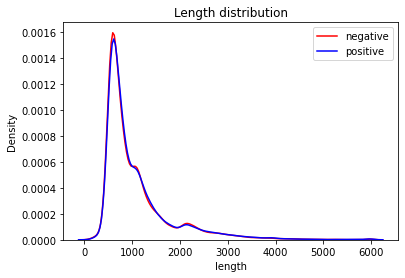

In [20]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

In [26]:
g = torch.Generator()
g.manual_seed(0)
data_loader_val = DataLoader(dataset_val, 32,
                             sampler=sampler_val, drop_last=False,
                             collate_fn=utils.collate_fn_nt3,
                             num_workers=2,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in tqdm(data_loader_val, total = len(data_loader_val)):
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/353 [00:00<?, ?it/s]

In [27]:
df_len.label.value_counts()

p    11282
n    11278
Name: label, dtype: int64

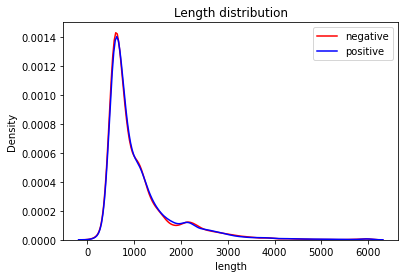

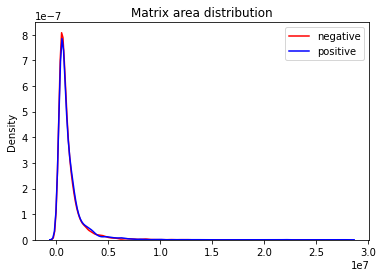

In [28]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

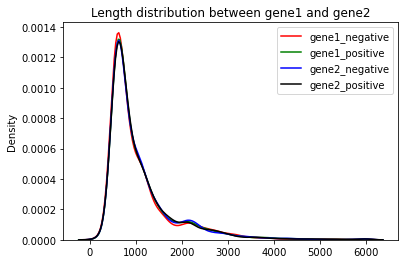

In [29]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [60]:
g = torch.Generator()
g.manual_seed(0)
data_loader_val = DataLoader(dataset_val, 32,
                             sampler=sampler_val, drop_last=False,
                             collate_fn=utils.collate_fn_nt2,
                             num_workers=2,
                             worker_init_fn=seed_worker, 
                             generator=g,)

s1_shapes = []
s2_shapes = []

for s, targets in tqdm(data_loader_val, total = len(data_loader_val)):
    s1_shapes.append(s[0].shape[-1])
    s2_shapes.append(s[1].shape[-1])

  0%|          | 0/353 [00:00<?, ?it/s]

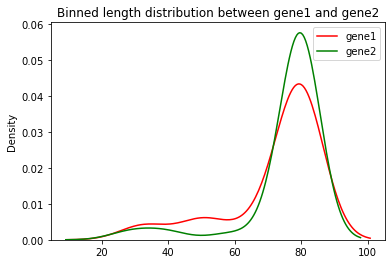

In [59]:
sns.kdeplot(s1_shapes, color = 'red', label = 'gene1')
sns.kdeplot(s2_shapes, color = 'green', label = 'gene2')
plt.title(f'Binned length distribution between gene1 and gene2')
plt.legend()
plt.show()

# Test 

In [29]:
pos_width_multipliers_test = pos_width_multipliers
pos_height_multipliers_test = pos_width_multipliers_test

neg_width_windows_test = neg_width_windows
neg_height_windows_test = neg_width_windows_test

assert np.round(sum(pos_width_multipliers_test.values()), 4) == np.round(sum(neg_width_windows_test.values()), 4) == 1    


policies_test = [
        EasyPosAugment(
            per_sample=2,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        EasyNegAugment(
            per_sample=0.04,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        HardPosAugment(
            per_sample=0.1,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        HardNegAugment(
            per_sample=0.04,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers_val,
        height_multipliers=pos_height_multipliers_val,
    ),
]

dataset_test = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"),
            augment_policies=policies_test,
)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)

In [30]:
g = torch.Generator()
g.manual_seed(0)
data_loader_test = DataLoader(dataset_test, 32,
                             sampler=sampler_test, drop_last=False,
                             collate_fn=utils.collate_fn,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in tqdm(data_loader_test, total = len(data_loader_test)):
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/1463 [00:00<?, ?it/s]

In [31]:
df_len.label.value_counts()

n    46900
p    46688
Name: label, dtype: int64

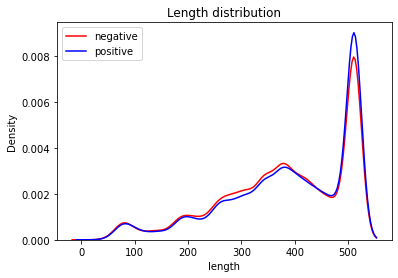

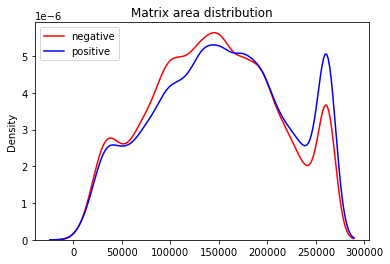

In [32]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

# Esecuzione data loader ricseq

In [ ]:
df_nt_ricseq = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt_ricseq.csv'))
df_genes_nt_ricseq = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt_ricseq.csv'))

In [62]:
vc_train = df_nt_ricseq.interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

pos_multipliers = {15:0.7, 20:0.2, 50:0.1, 100:0.1}
neg_multipliers = {20:0.4,
                   30:0.3,
                   50:0.1,
                   70:0.1,
                   250:0.1}


policies_train = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
    
    
dataset_train = RNADataset(
        gene2info=df_genes_nt_ricseq,
        interactions=df_nt_ricseq,
        subset_file='',
        augment_policies=policies_train,
)

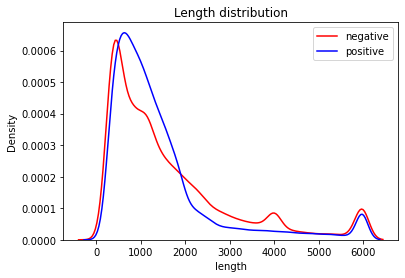

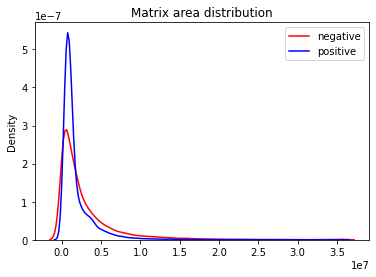

In [64]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

# FINETUNING SPLASH

In [5]:
PERC_TRAIN = 0.7
DATASET = 'splash'
df = pd.read_csv(os.path.join(processed_files_dir, f'final_splash_RANDOM.csv'))
df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_SPLASH.csv'))

def obtain_train_test_lists(df_pairs_full):
    df_pairs_full = df_pairs_full.sample(frac = 1, random_state = 23)
    n_train_pairs = int(df_pairs_full.shape[0]*PERC_TRAIN)
    n_test_pairs = df_pairs_full.shape[0] - n_train_pairs
    df_pairs_full_train, df_pairs_full_test = df_pairs_full.head(n_train_pairs), df_pairs_full.tail(n_test_pairs)
    assert (pd.concat([df_pairs_full_train, df_pairs_full_test], axis = 0) == df_pairs_full).all().all()
    train_couples = set(df_pairs_full_train.positive).union(df_pairs_full_train.negative)
    test_couples = set(df_pairs_full_test.positive).union(df_pairs_full_test.negative)
    print(f'The number of equal couples between train and test is {len(train_couples.intersection(test_couples))}, \
    which is the {np.round(len(train_couples.intersection(test_couples))/len(train_couples.union(test_couples)) * 100, 2)}%')
    assert test_couples.union(train_couples) == set(df_pairs_full.positive).union(df_pairs_full.negative)
    return list(train_couples), list(test_couples)

train_couples, test_couples = obtain_train_test_lists(df_pairs_full)
df_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_nt_{DATASET}.csv'))
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, 'RANDOM', f'df_genes_nt_{DATASET}.csv'))

The number of equal couples between train and test is 240,     which is the 15.25%


In [10]:
train_nt = df_nt[df_nt.couples_id.isin(train_couples)]

vc_train = train_nt.interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

pos_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}
neg_multipliers = {5:0.7, 15:0.2, 50:0.1, 100:0.1}


policies_train = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
    
    
dataset_train = RNADataset(
        gene2info=df_genes_nt,
        interactions=train_nt,
        subset_file='',
        augment_policies=policies_train,
)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

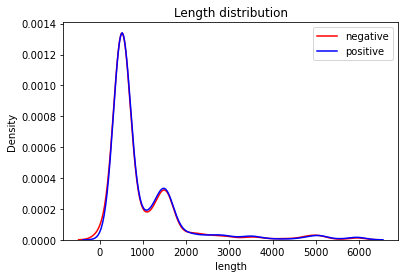

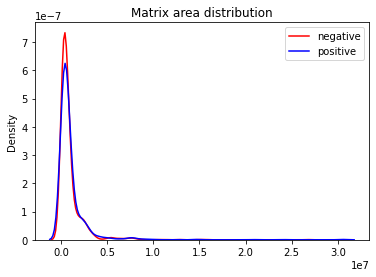

In [11]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()